## 3-1、低阶API示范
下面的范例使用Tensorflow的低阶API实现线性回归模型和DNN分类模型。   

低阶API主要包括张量操作，计算图和自动微分。

In [20]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

### 一、线性回归模型
#### 1、准备数据

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

#样本数量
n =400

#生成测试数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10)
w0= tf.constant([[2.0],[-3.0]])
b0= tf.constant([3.0])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

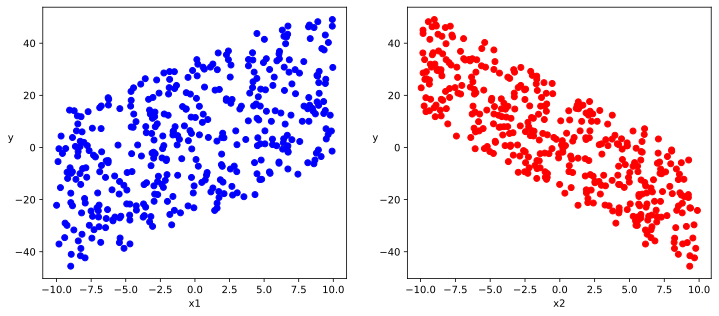

In [10]:
#数据可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0],c="b")
plt.xlabel("x1")
plt.ylabel("y",rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0],c ='r')
plt.xlabel("x2")
plt.ylabel("y",rotation=0)
plt.show()

In [11]:
#构建迭代器
def data_iter(features,labels,batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        indexs = indices[i:min(i+batch_size,num_examples)]
        yield tf.gather(X,indexs),tf.gather(Y,indexs)
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[-3.1719732  0.6794052]
 [-0.7596636 -2.838149 ]
 [ 7.88295    1.4691086]
 [ 8.866148  -1.6564732]
 [-8.156813  -6.0549545]
 [-4.8986816  0.9195185]
 [ 7.577429   5.9027214]
 [-2.937889  -0.7747574]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[-6.998873 ]
 [ 8.274102 ]
 [15.866428 ]
 [27.367807 ]
 [ 5.9895306]
 [-9.617259 ]
 [ 2.2829032]
 [-2.376378 ]], shape=(8, 1), dtype=float32)


#### 2、定义模型

In [14]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

#定义模型
class LinearRegression:
    #正向传播
    def __call__(self,x):
        return x@w + b
    
    def loss_func(self,y_true,y_pred):
        return tf.reduce_mean((y_true-y_pred)**2/2)

model = LinearRegression()

#### 3、训练模型

In [15]:
#使用动态图调试

def train_step(model,features,labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels,predictions)
    #反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

In [17]:
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=358.41367>

In [21]:
def train_model(model,epochs):
    for epoch in range(epochs):
        for features,labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%10 == 0:
            printbar()
            tf.print("epoch = ",epoch,"loss = ",loss)
            tf.print("w = ",w)
            tf.print("b = ",b)
train_model(model,epochs=200)

================================================================================11:29:35
epoch =  0 loss =  12.6557837
w =  [[1.90044725]
 [-2.74290943]]
b =  [0.231191114]
================================================================================11:29:35
epoch =  10 loss =  2.49911022
w =  [[2.00658417]
 [-3.00029278]]
b =  [1.12608182]
================================================================================11:29:36
epoch =  20 loss =  1.26467443
w =  [[2.01464295]
 [-3.00066924]]
b =  [1.72600722]
================================================================================11:29:37
epoch =  30 loss =  1.14569235
w =  [[2.00877261]
 [-3.00826502]]
b =  [2.12843919]
================================================================================11:29:38
epoch =  40 loss =  2.29524899
w =  [[2.02411771]
 [-3.00201178]]
b =  [2.39708]
================================================================================11:29:38
epoch =  50 loss =  2.4096427
w =  [[2.02663922]


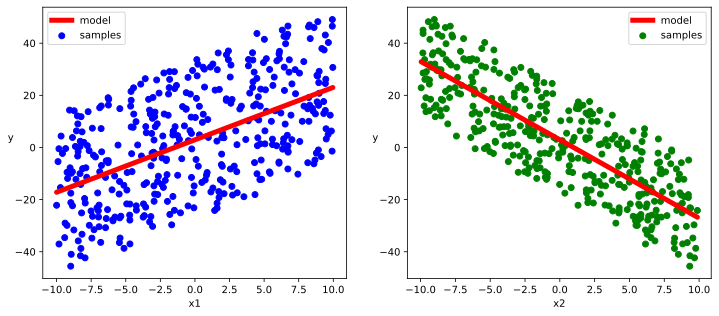

In [22]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

### 二、DNN分类模型
#### 1、准备数据

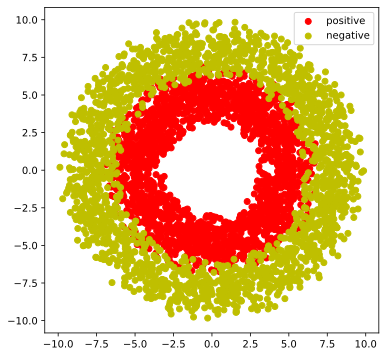

In [25]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "y")
plt.legend(["positive","negative"]);

In [24]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(X,indexs), tf.gather(Y,indexs)
        
# 测试数据管道效果   
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 4.082029    5.4531474 ]
 [ 9.277576    0.91035867]
 [-3.9104466  -0.43526176]
 [ 8.697858   -1.4720131 ]
 [-2.4497902   3.288048  ]
 [-4.2007823   1.133861  ]
 [-6.8058105  -2.2818859 ]
 [-3.8527796   1.4822369 ]
 [ 7.385827   -0.21157102]
 [ 2.4860091  -8.118567  ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]], shape=(10, 1), dtype=float32)


#### 2、定义模型
此处范例我们利用tf.Module来组织模型变量，关于tf.Module的较详细介绍参考本书第四章最后一节: Autograph和tf.Module。

In [26]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)])  
    def loss_func(self,y_true,y_pred):  
        #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return  tf.reduce_mean(bce)
    
    # 评估指标(准确率)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)]) 
    def metric_func(self,y_true,y_pred):
        y_pred = tf.where(y_pred>0.5,tf.ones_like(y_pred,dtype = tf.float32),
                          tf.zeros_like(y_pred,dtype = tf.float32))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc
    
model = DNNModel()

In [27]:
#测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)
loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric:",metric)

init loss: 1.9170984
init metric: 0.2


In [28]:
print(len(model.trainable_variables))

6


#### 3、训练模型

In [32]:
#使用autograph机制转换成静态图加速
@tf.function
def train_step(model,features,labels):
    #正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels,predictions)
        
    grads = tape.gradient(loss,model.trainable_variables)
    for p,dloss_dp in zip(model.trainable_variables,grads):
        p.assign(p - 0.001*dloss_dp)
        
    metric = model.metric_func(labels,predictions)
    return loss,metric

def train_model(model,epochs):
    for epoch in range(epochs):
        for features,labels in data_iter(X,Y,100):
            loss,metric = train_step(model,features,labels)
        if epoch%100==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)
train_model(model,epochs=600)

================================================================================12:12:58
epoch = 0 loss =  1.0241611 accuracy =  0.46
================================================================================12:13:02
epoch = 100 loss =  0.668893576 accuracy =  0.54
================================================================================12:13:07
epoch = 200 loss =  0.60756892 accuracy =  0.62
================================================================================12:13:11
epoch = 300 loss =  0.629530609 accuracy =  0.64
================================================================================12:13:16
epoch = 400 loss =  0.576164782 accuracy =  0.67
================================================================================12:13:20
epoch = 500 loss =  0.599905312 accuracy =  0.69


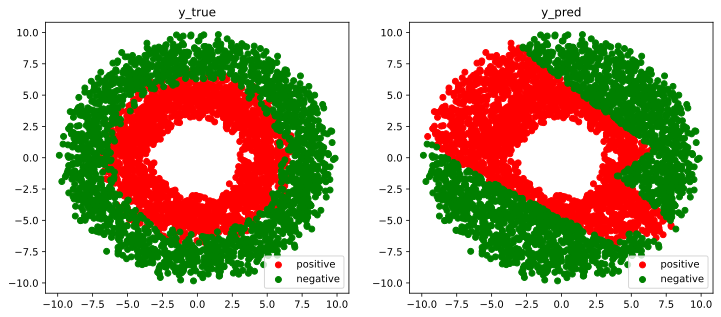

In [33]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");